In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import pandas as pd
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Preview
At a first look, the table **train.csv** contains the training labels and masks. The table contains `ImageID_ClassID`, which is `ImageID` (unique image identifier) and `ClassID` (defect type) concatenated into one column, as well as an `EncodedPixels` column containing pixels of the defect mask (in run-length encoding format). Separate `ImageID` and `ClassID` into their own columns

In [8]:
train_df = pd.read_csv('kaggle/input/train.csv')
train_df['ImageID'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassID'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df.head()

,ImageId_ClassId,EncodedPixels,ImageID,ClassID
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4
4,00031f466.jpg_1,NaN,00031f466.jpg,1


Define functions for data input/output.

In [17]:
def rle2masks(img, masks_enc):
    '''decode run-length encoding (RLE) in EncodedPixels and generate 2D defect mask
    INPUT: img: 2D nparray, masks_enc: df containing encoded mask pixels
    OUTPUT: masks: 2D nparray with 4 defect masks
    '''
    sr, sc, sz = img.shape
    print(sr, sc, sz)
    masks = np.zeros((sr, sc, 4), dtype=np.uint8)
    # generate 2D mask from RLE mask
    for i in range(masks_enc.shape[0]):
        mask_enc = masks_enc.iloc[i]
        mask_idx = np.array([], dtype=int)
        # decode RLE
        if isinstance(mask_enc, str):
            encoded_array = np.asarray(mask_enc.split()).astype(int)
            start_pos = encoded_array[0::2]
            run_len = encoded_array[1::2]
            for idx in range(len(start_pos)):
                curr_idx = np.arange(start_pos[idx], start_pos[idx]+run_len[idx]+1, 1)
                mask_idx = np.concatenate((mask_idx, curr_idx))
        elif isinstance(mask_enc, float):
            mask_id = 0
        mask = np.zeros((sr, sc)).flatten()
        mask[mask_idx] = 1            
        masks[:,:,i] = mask.reshape((sr, sc), order='F')
    return masks

def masks2rle(mask):
    '''(TODO) encode RLE of mask for submission'''
    pass

def show_imgs(img, masks):
    '''show steel image overlaid with contours of detect mask'''
    palet = [(255, 255, 0), (0, 255, 255), (255, 0, 255), (0, 255, 0)]
    for i in range(masks.shape[2]):
        contours, _ = cv2.findContours(masks[:,:,i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for ii in range(len(contours)):
            cv2.polylines(img, contours[ii], True, palet[i], 2)
    plt.figure(figsize=(20, 10))
    plt.imshow(img)
    plt.draw()
    
def preprocess(df, fdir, img_id):
    '''decode RLE, make masks (if it exists)'''
    img = cv2.imread(fdir + img_id)
    masks_enc = df[df['ImageID'] == img_id]['EncodedPixels']
    masks = rle2masks(img, masks_enc)
    show_imgs(img, masks)


Let's preview some of the steel images and their defects by overlaying images with labeled defects. Note that each color represents a different defect ID.

%d, %d, %d 256 1600 3
%d, %d, %d 256 1600 3
%d, %d, %d 256 1600 3
%d, %d, %d 256 1600 3
%d, %d, %d 256 1600 3
%d, %d, %d 256 1600 3
%d, %d, %d 256 1600 3
%d, %d, %d 256 1600 3
%d, %d, %d 256 1600 3
%d, %d, %d 256 1600 3


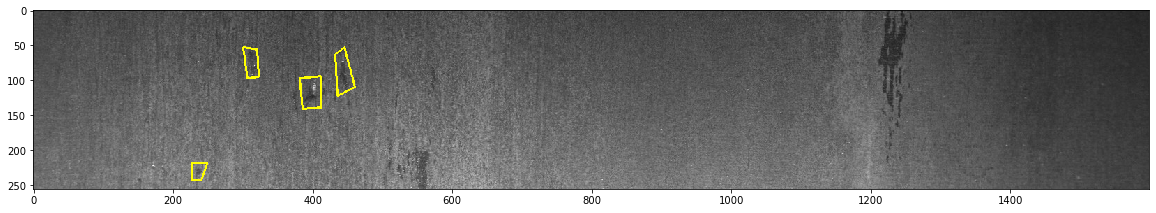

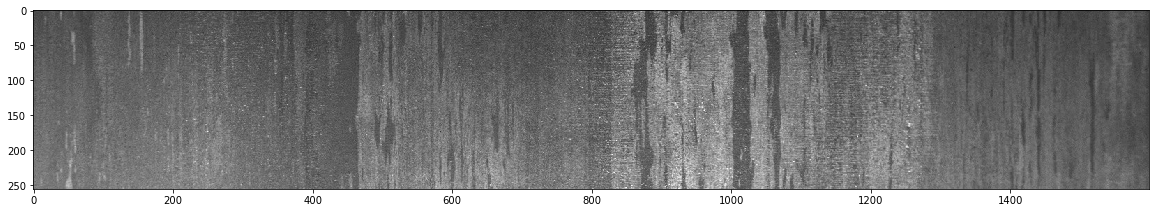

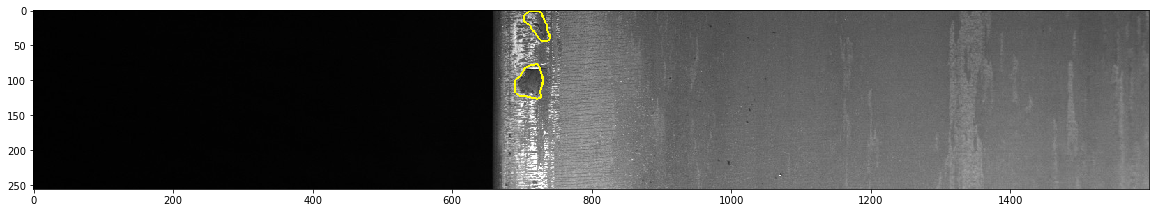

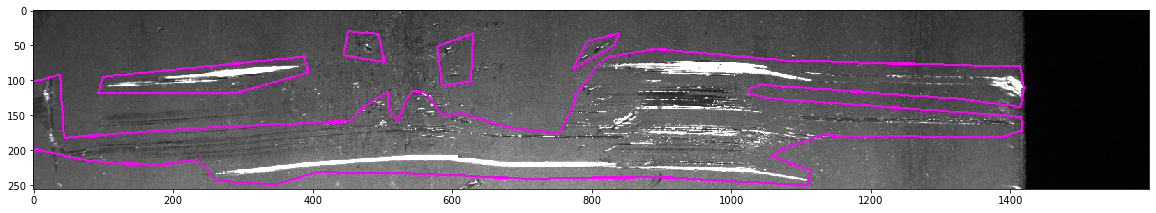

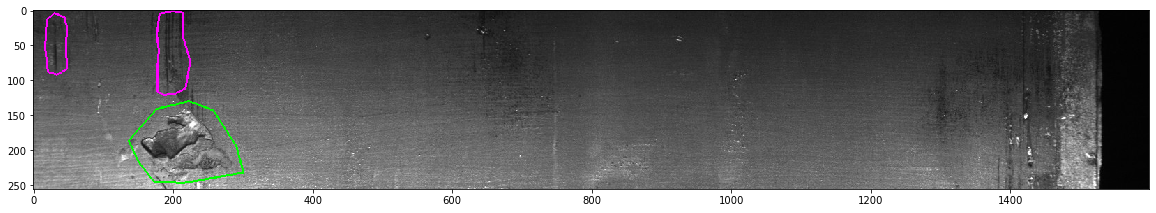

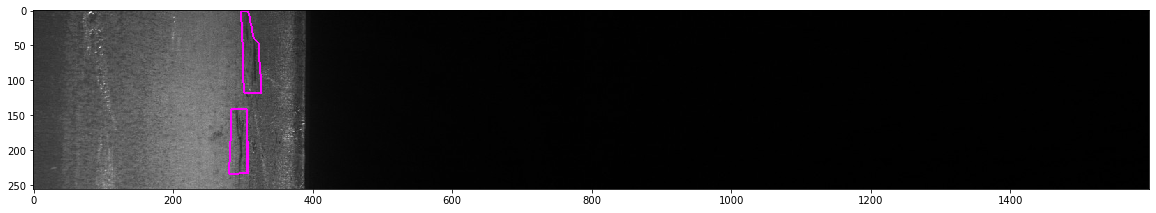

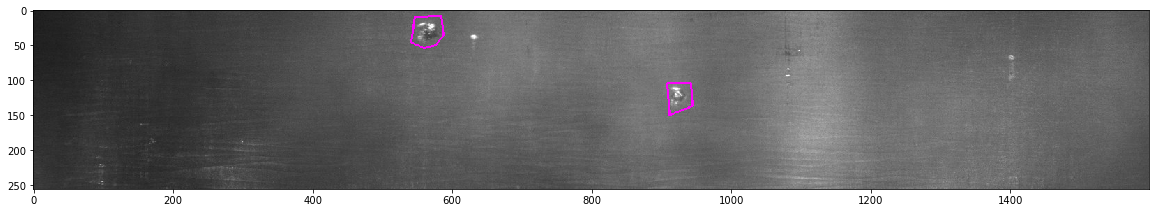

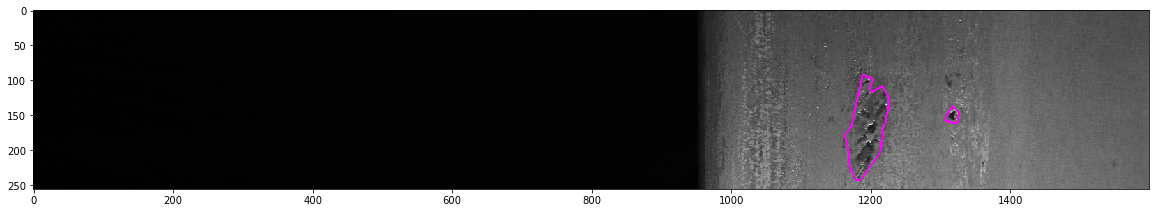

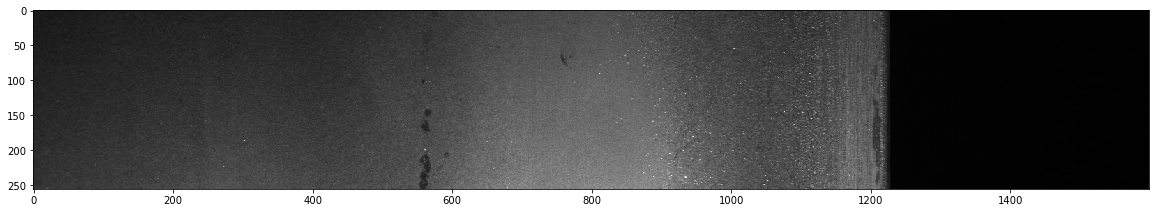

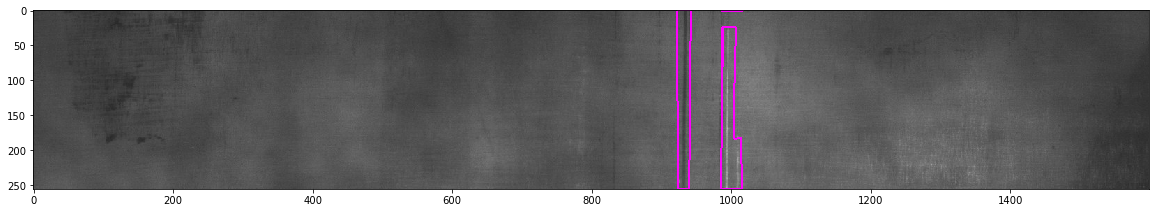

In [18]:
id_unique = train_df['ImageID'].unique()
fdir = 'kaggle/input/'
for i in range(60, 70, 1):
    img_id = id_unique[i]
    preprocess(train_df, fdir, img_id)

Check the composition of the data, i.e. the percetange of each defect class in the total dataset.

In [13]:
train_df[train_df['EncodedPixels'].notnull()]['ClassID'].value_counts() / train_df['ImageID'].unique().shape

3    0.409771
1    0.071372
4    0.063733
2    0.019653
Name: ClassID, dtype: float64

\>50% of the images do not have defects.